In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, Input, Lambda, LSTM, MaxPooling2D, Reshape
from tensorflow.keras import backend as K
import tensorflow as tf

/home/sergeyk/.local/share/virtualenvs/fsdl-text-recognizer-6Tfq_pVK/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [9]:
DATA_DIRNAME = Path('/home/sergeyk/work/iamdb')

crop_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped').glob('*.jpg')))
gt_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped-gt').glob('*.png')))

print(len(crop_filenames))

NUM_LABELS = 2

X = []
Y = []
for ind in range(len(crop_filenames)):
    name = crop_filenames[ind].stem
    image = cv2.imread(str(crop_filenames[ind]), cv2.IMREAD_GRAYSCALE)
    
    gt_filename = DATA_DIRNAME / 'forms-cropped-gt' / f'{name}.png'
    gt_image = cv2.imread(str(gt_filename), cv2.IMREAD_GRAYSCALE)
    
    # only have three labels: background, odd lines, even lines
    for value in np.unique(gt_image):
        gt_image[gt_image == (value + 1)] = value % 2 + 1
    
    # get rid of even lines
    gt_image[gt_image == 2] = 0
    
    X.append(image / 255)
    Y.append(to_categorical(gt_image.flatten(), NUM_LABELS))
    
X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.uint8)
print(X.shape, X.dtype, Y.shape, Y.dtype)

# For training
X_train = X[:1000]
X_test = X[1000:]
Y_train = Y[:1000]
Y_test = Y[1000:]

# For overfitting
X_single = np.repeat(X[0:1], X.shape[0], axis=0)
Y_single = np.repeat(Y[0:1], Y.shape[0], axis=0)

1537
(1537, 633, 620) float32 (1537, 392460, 2) uint8


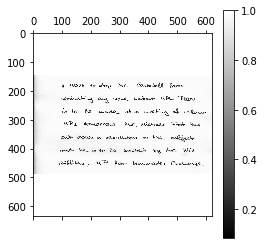

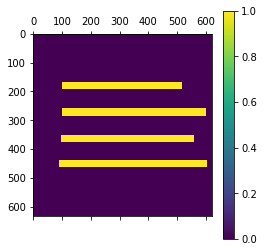

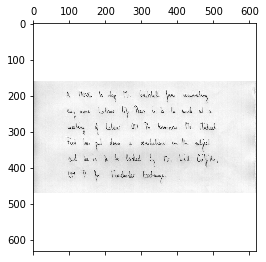

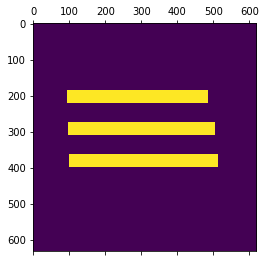

In [4]:
MAX_HEIGHT, MAX_WIDTH = X[0].shape

plt.matshow(X[0], cmap='gray')
plt.colorbar()

plt.matshow(Y[0].reshape((MAX_HEIGHT, MAX_WIDTH, NUM_LABELS)).argmax(axis=-1))
plt.colorbar()

plt.matshow(X[1], cmap='gray')
plt.matshow(Y[1].reshape((MAX_HEIGHT, MAX_WIDTH, NUM_LABELS)).argmax(axis=-1))

In [34]:
# This is a DenseNet-y kind of network, with dilation used to increase receptive field.

def conv_block(inputs, num_filters, kernel_size, dilation_rate, activation, batch_norm=False):
    conv = Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, use_bias=(not batch_norm), padding='same')(inputs)
    if batch_norm:
        conv = BatchNormalization()(conv)
    return Activation(activation)(conv)

input_image = Input((MAX_HEIGHT, MAX_WIDTH))
input_image_reshaped = Reshape((MAX_HEIGHT, MAX_WIDTH, 1))(input_image)

initial_conv = conv_block(input_image_reshaped, 32, 3, 1, 'relu')

conv = conv_block(initial_conv, 16, 5, 5, 'relu')
cat = Concatenate()([initial_conv, conv])

conv = conv_block(cat, 16, 5, 7, 'relu')
cat = Concatenate()([cat, conv])

conv = conv_block(cat, 16, 5, 9, 'relu')
cat = Concatenate()([cat, conv])

conv = conv_block(cat, 16, 5, 11, 'relu')
pred = conv_block(conv, NUM_LABELS, 1, 1, 'softmax')

output = Reshape((MAX_HEIGHT * MAX_WIDTH, NUM_LABELS))(pred)
model = Model(inputs=input_image, outputs=output)
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)
]
history = model.fit(
    x=X_single,
    y=Y_single,
    epochs=32,
    batch_size=8,
    validation_data=(X_test, Y_test),
    callbacks=callbacks
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 633, 620)     0                                            
__________________________________________________________________________________________________
reshape_28 (Reshape)            (None, 633, 620, 1)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 633, 620, 32) 288         reshape_28[0][0]                 
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 633, 620, 32) 128         conv2d_80[0][0]                  
__________________________________________________________________________________________________
activation

KeyboardInterrupt: 

In [32]:
model.evaluate(X_test, Y_test, batch_size=16)

537/537 [==============================] - 21s 39ms/step


[0.3716406823869524, 0.8521113418999997]

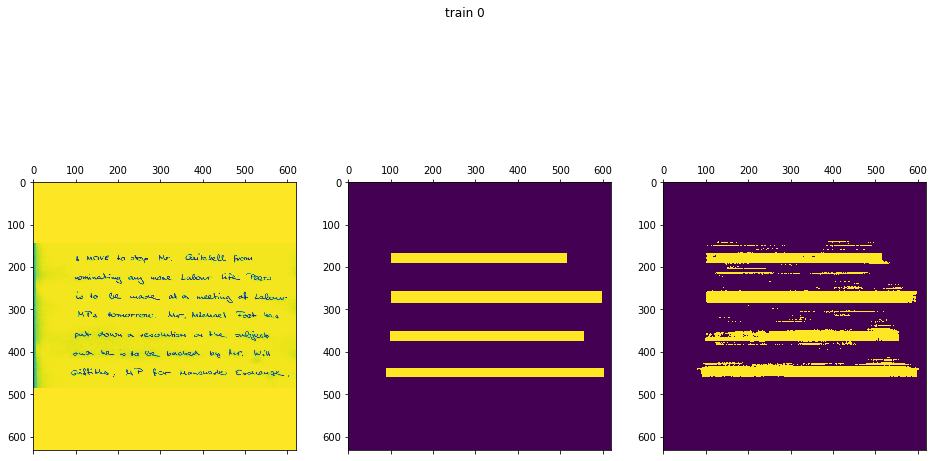

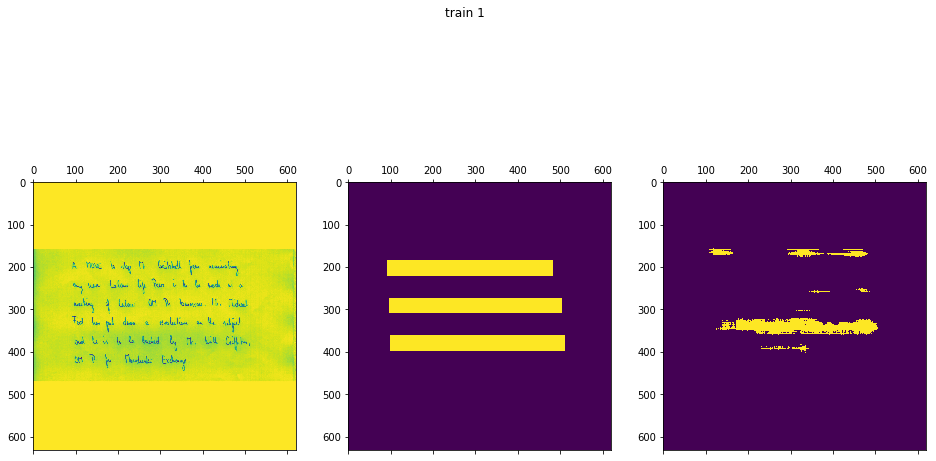

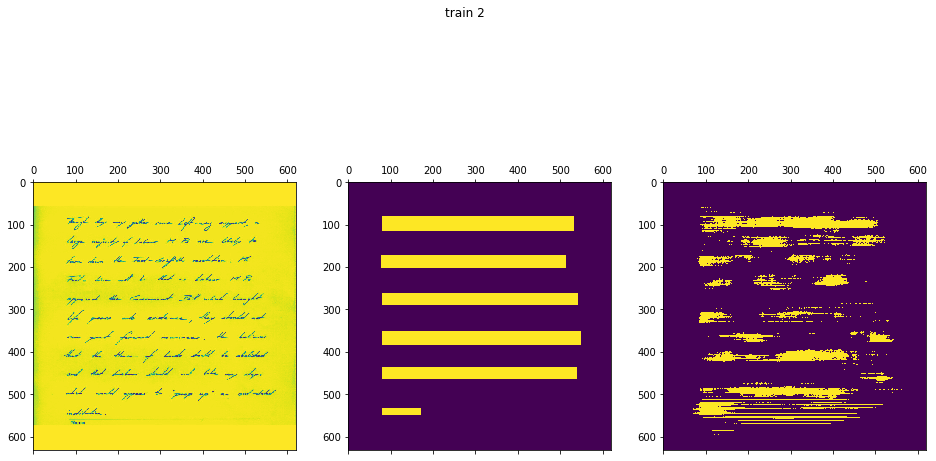

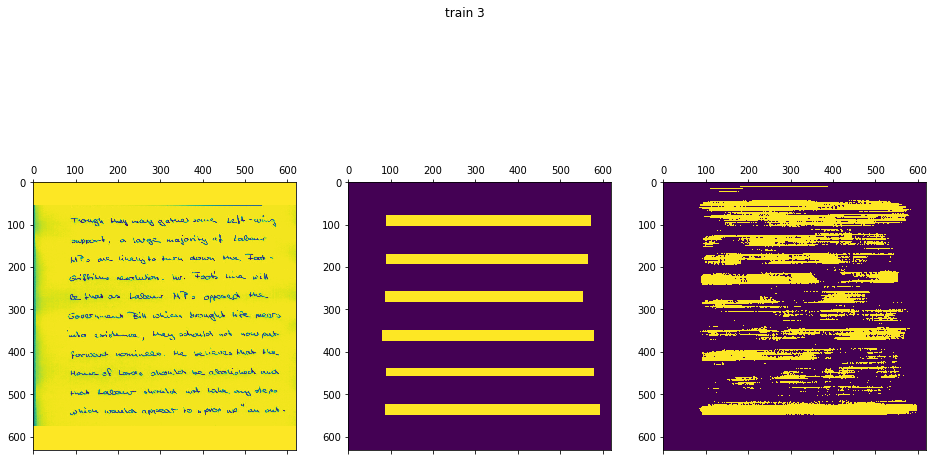

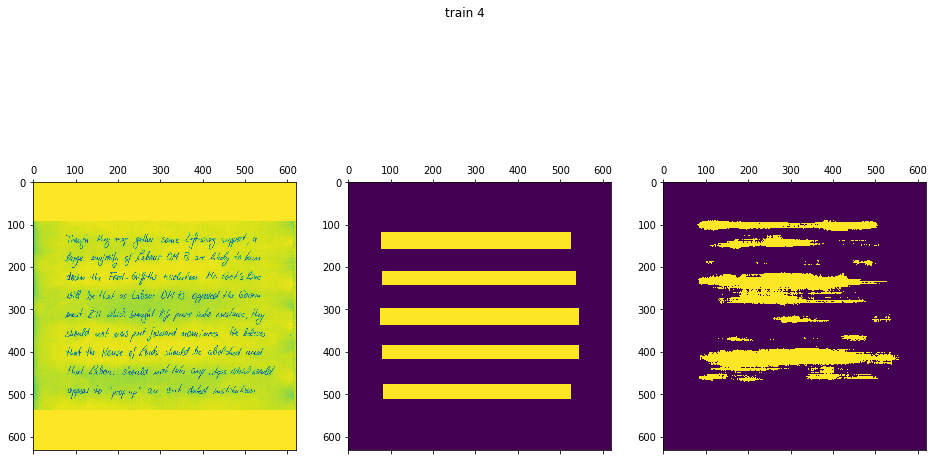

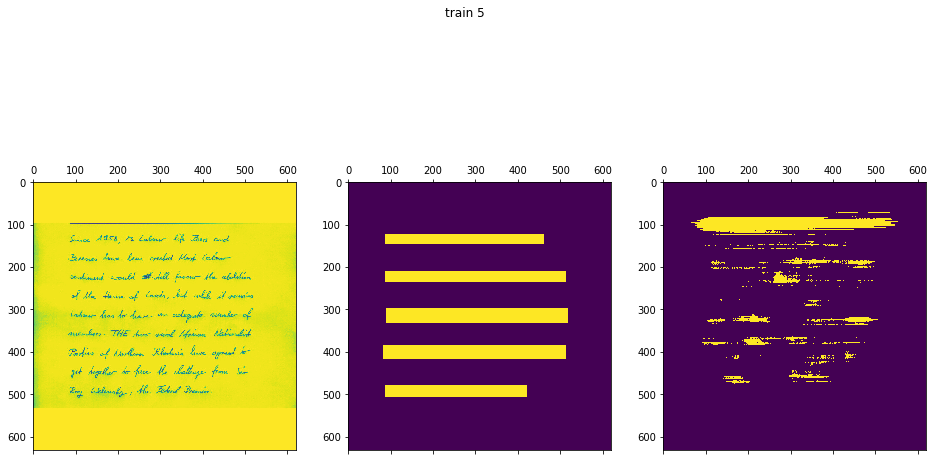

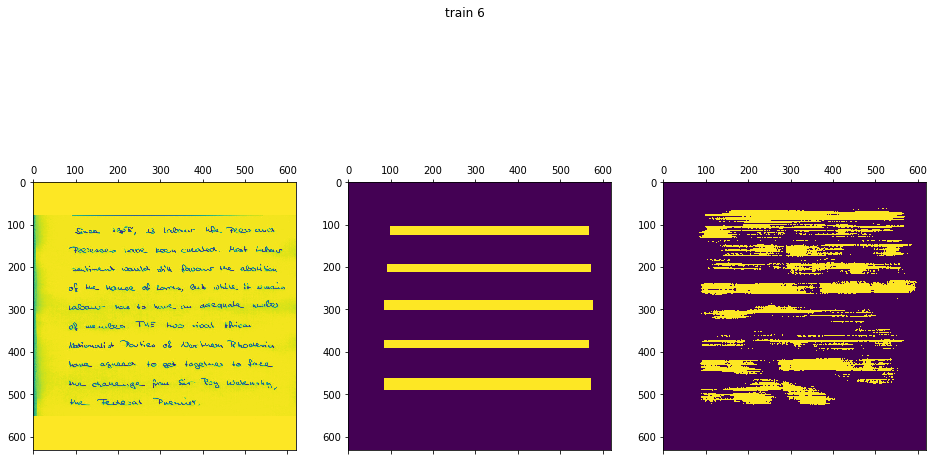

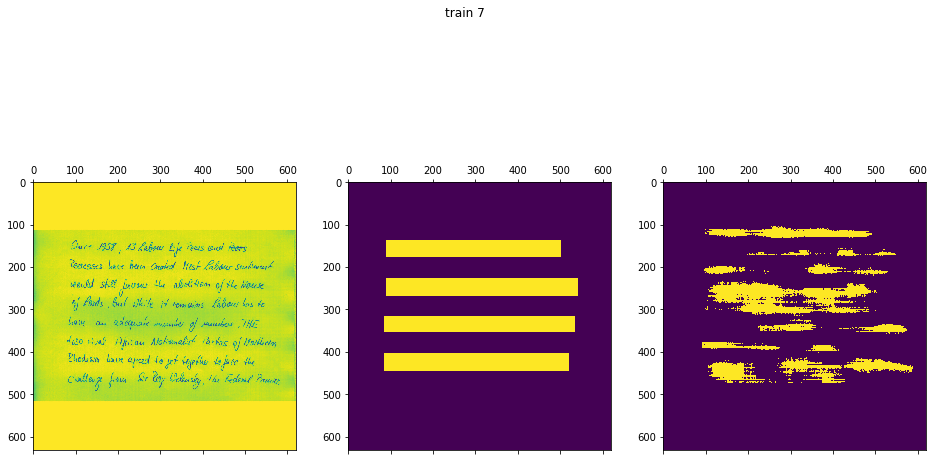

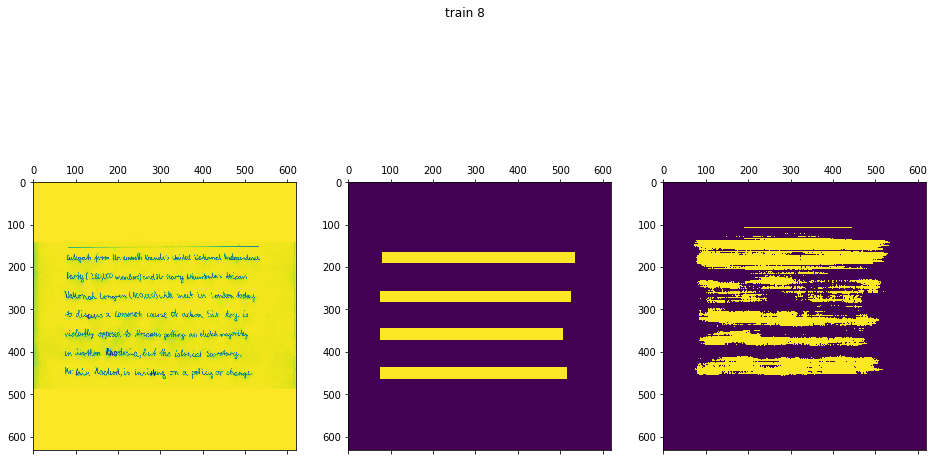

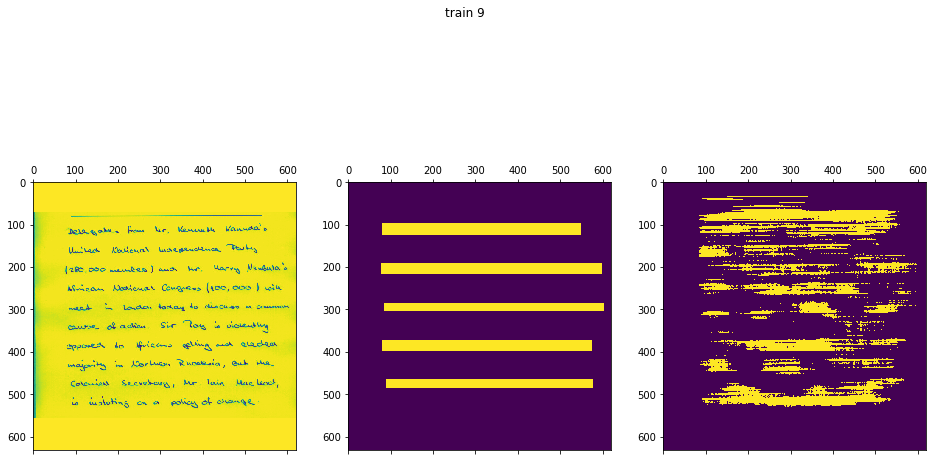

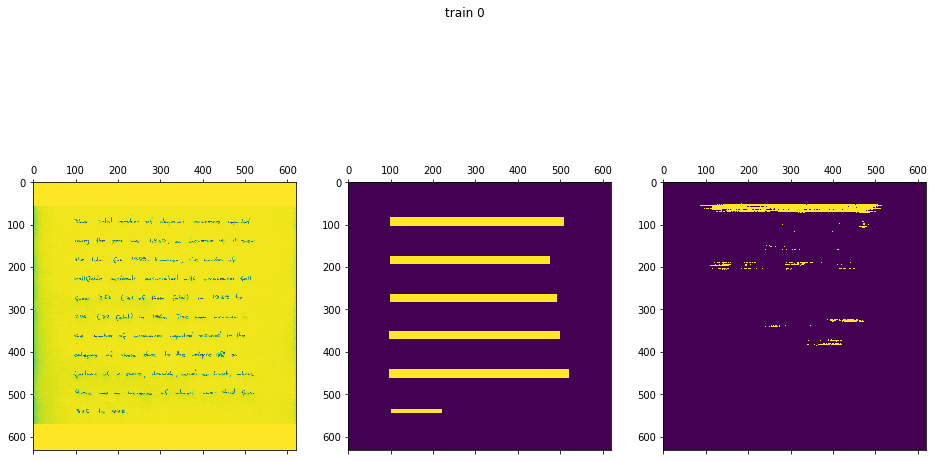

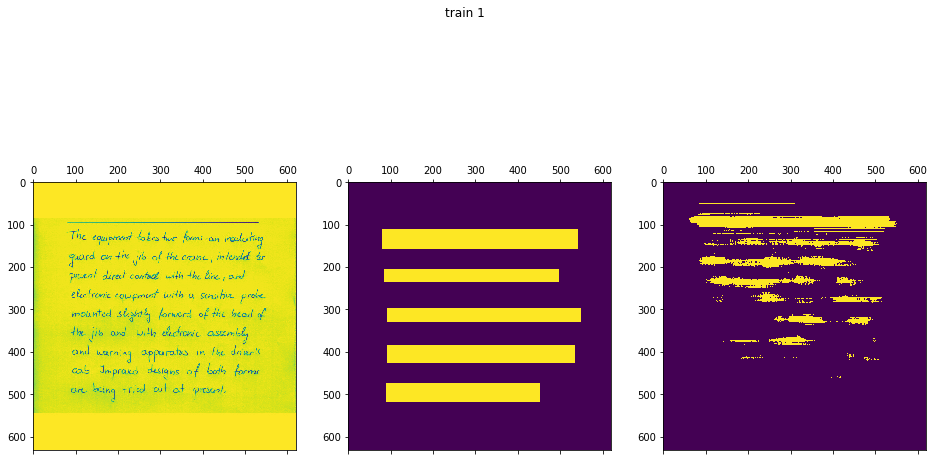

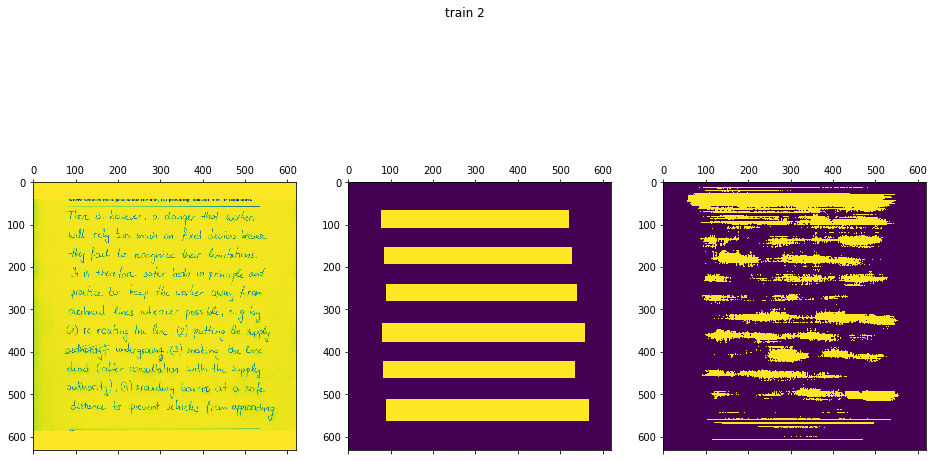

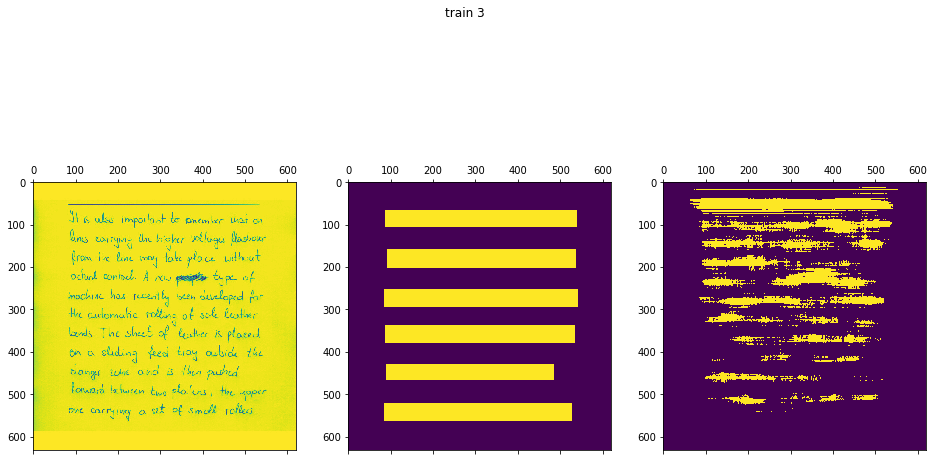

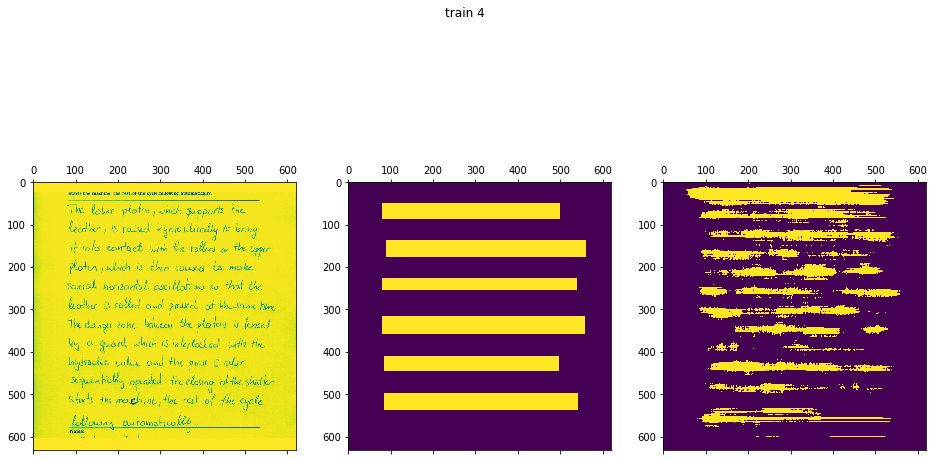

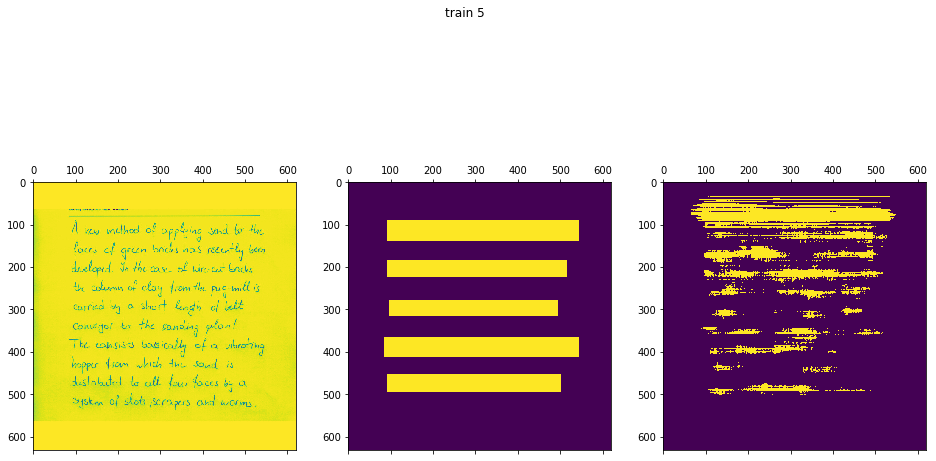

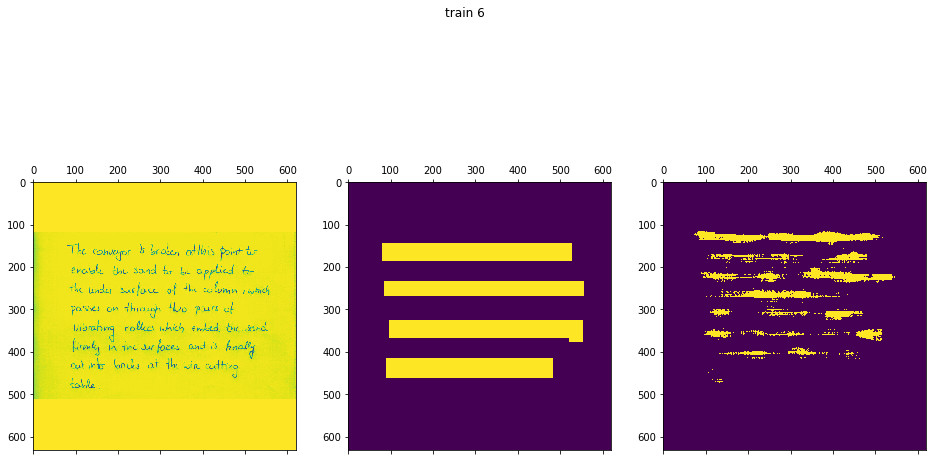

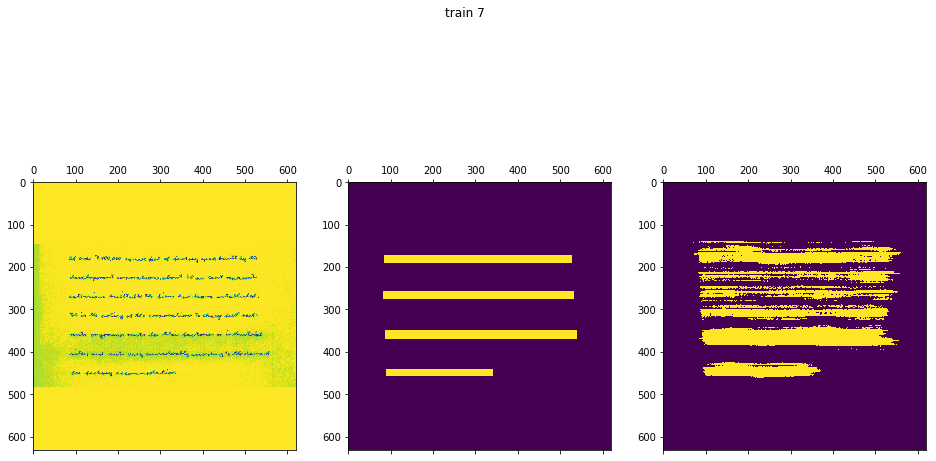

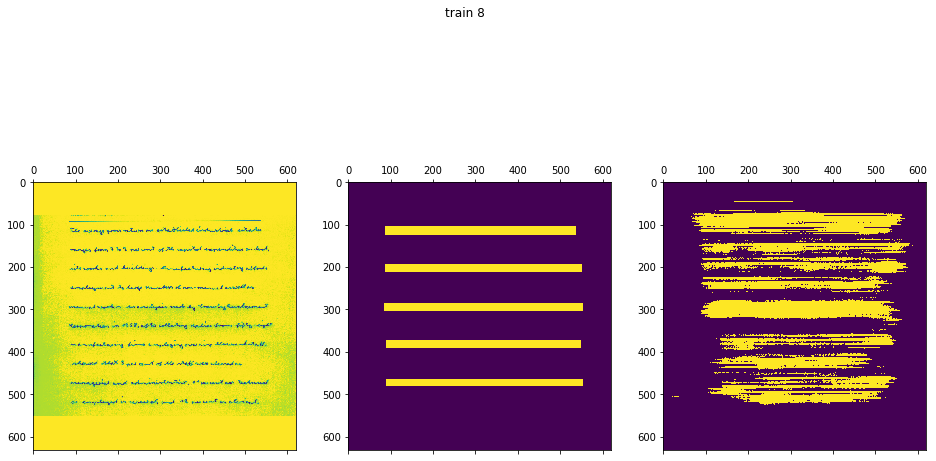

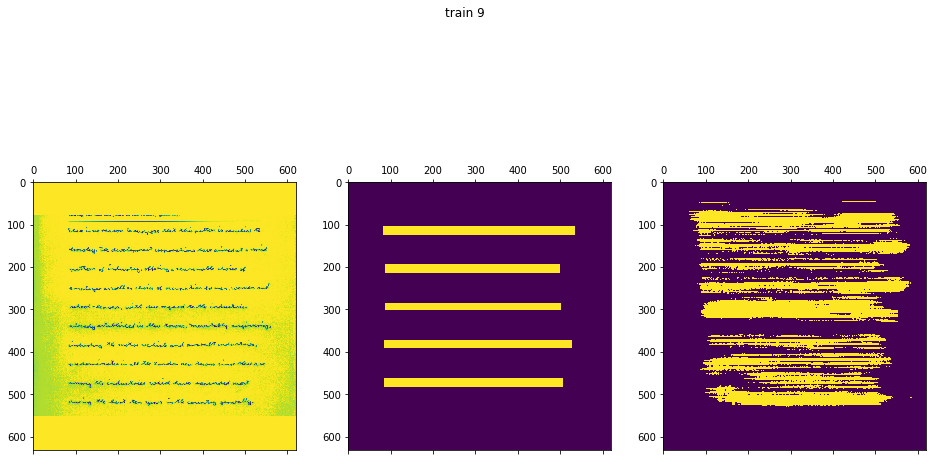

In [35]:
def plot_gt_and_pred(X, Y, preds, ind, split_name):
    gt = Y[ind].reshape(MAX_HEIGHT, MAX_WIDTH, -1).argmax(-1)
    pred = preds[ind].reshape(MAX_HEIGHT, MAX_WIDTH, -1).argmax(-1)
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f'{split_name} {ind}')
    ax1 = fig.add_subplot(131)
    ax1.matshow(X[ind].squeeze())
    ax2 = fig.add_subplot(132)
    ax2.matshow(gt)
    ax3 = fig.add_subplot(133)
    ax3.matshow(pred)

NUM_TO_PRED = 10
train_preds = model.predict(X[:NUM_TO_PRED])
for ind in range(NUM_TO_PRED):
    plot_gt_and_pred(X, Y, train_preds, ind, 'train')

test_preds = model.predict(X_test[:NUM_TO_PRED])
for ind in range(NUM_TO_PRED):
    plot_gt_and_pred(X_test, Y_test, test_preds, ind, 'train')